In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class MLP_Encoder(nn.Module):
    def __init__(self, args):
        super(MLP_Encoder, self).__init__()



        self.embed = nn.Linear(args.L, args.latent_dims)
        self.dropout = nn.Dropout(p=args.slope)
        
        # MLP Layers for Mu and logvar output
        self.encoder_mu = nn.Sequential(
                                nn.Linear(args.latent_dims, args.latent_dims),  # Linear layer 
                                nn.ReLU(True)  # Sigmoid activation function
                            )
#         nn.Linear(self.lin_input, self.lin_output)
        self.encoder_logvar = nn.Sequential(
                                nn.Linear(args.latent_dims, args.latent_dims),  # Linear layer 
                                nn.ReLU(True)  # Sigmoid activation function
                            )
    
    def forward(self, x):
        x = self.dropout(self.embed(x))
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar
    
class MLP_Decoder(nn.Module):
    def __init__(self, args):
        super(MLP_Decoder, self).__init__()



        self.embed = nn.Linear(args.latent_dims, args.L)
        self.dropout = nn.Dropout(p=args.slope)
        
        # MLP Layers for Mu and logvar output
        self.decoder_mu = nn.Sequential(
                                nn.Linear(args.L, args.L),  # Linear layer 
                                nn.ReLU(True)  # Sigmoid activation function
                            )
#         nn.Linear(self.lin_input, self.lin_output)
        self.decoder_logvar = nn.Sequential(
                                nn.Linear(args.L, args.L),  # Linear layer 
                                nn.ReLU(True)  # Sigmoid activation function
                            )
        
    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.dropout(self.embed(x))
        print("after dropout", x.shape)
        mu = self.decoder_mu(x)
        logvar = self.decoder_logvar(x)
        print("after dropout", mu.shape)
        x = self.reparametrization_trick(mu, logvar)
        print("output", x.shape)
        return x, mu, logvar
        
        
class AttentionLayer(nn.Module):
    def __init__(self, args, n_heads, mask, d_keys=None, d_values=None):
        super(AttentionLayer, self).__init__()
        
        self.latent_dims = args.latent_dims
        self.n_heads = n_heads
        self.mask = mask
        self.d_keys = d_keys or (self.latent_dims // self.n_heads)
        self.d_values = d_values or (self.latent_dims // self.n_heads)

        self.query_projection = nn.Linear(self.latent_dims, self.d_keys * self.n_heads)
        self.key_projection = nn.Linear(self.latent_dims, self.d_keys * self.n_heads)
        self.value_projection = nn.Linear(self.latent_dims, self.d_values * self.n_heads)
        self.out_projection = nn.Linear(self.d_values * self.n_heads, self.latent_dims)

    def forward(self, queries, keys, values, attn_mask=None):
        B, Nq, _ = queries.shape
        _, Nk, _ = keys.shape
        H = self.n_heads

        q = self.query_projection(queries).view(B, Nq, H, -1).transpose(1 ,2) # B x H x N* x SH
        k = self.key_projection(keys).view(B, Nk, H, -1).transpose(1 ,2)         # B x H x N* x SH
        v = self.value_projection(values).view(B, Nk, H, -1).transpose(1 ,2)   # B x H x N* x SH
        
        prod = torch.matmul(q, k.transpose(-1, -2)) # B x H x N* x N*
        
        if self.mask is not None:
            prod = prod.masked_fill(attn_mask, -np.inf)
        
        scores = F.softmax(prod / np.sqrt(self.d_keys), dim=-1)  # B x H x N* x N*
        
        out = torch.matmul(scores, v)  # B x H x N* x SH
        
        out = out.transpose(1,2).contiguous().view(B, Nk, -1)
        

        return self.out_projection(out), scores

class TransformerBlock(nn.Module):
    def __init__(self, args, attn):
        super(TransformerBlock, self).__init__()
        

        self.attn = attn(args, 8, None)
        self.dropout1 = nn.Dropout(p=args.slope)
        self.dropout2 = nn.Dropout(p=args.slope)
        self.norm1 = nn.LayerNorm(args.latent_dims)
        self.norm2 = nn.LayerNorm(args.latent_dims)
        self.feed_forward = nn.Sequential(
                          nn.Linear(args.latent_dims, args.exp_factor*args.latent_dims),
                          nn.ReLU(),
                          nn.Linear(args.exp_factor*args.latent_dims, args.latent_dims)
        )

    def forward(self, x, attn_mask=None):

        att_out, scores = self.attn(x,x,x)  
        att_res = att_out + x  
        norm1_out = self.dropout1(self.norm1(att_res)) 

        ff = self.feed_forward(norm1_out) 
        ffr = ff + norm1_out #32x10x512
        out = self.dropout2(self.norm2(ffr)) #32x10x512
        
        return out, scores
    
class TransformerEnc(nn.Module):
    def __init__(self, args, trs_block, n_layers, attn):
        super(TransformerEnc, self).__init__()
        
        self.trs_layers = nn.ModuleList()        
        for i in range(n_layers):
            self.trs_layers.append(trs_block(args, attn))

    def forward(self, x):

        for layer in self.trs_layers:
            x, scores = layer(x)        
        return x, scores

class TransformerVAE(nn.Module):
    def __init__(self, args, v_encoder, v_decoder, v_att):
        super(TransformerVAE, self).__init__()
        
        
        self.model_type = "VAET"
        self._n_channels = args.n_channels
        self._num_layers = args.num_layers
        self._latent_dims = args.latent_dims
        self._v_encoder = v_encoder
        self._v_decoder = v_decoder
        self._v_att = v_att
        #         self._v_quantizer = v_quantizer
        self._L = args.L
        self._slope = args.slope
        self._first_kernel = args.first_kernel
        self._ß = args.ß
        self._reduction = args.reduction
        self._modified = args.modified
        self._robust = args.robust
        #         if self._modified:
        #             self._num_embed = self._n_channels * 4 * self._num_layers
        #         else:
        #             self._num_embed = self._n_channels * 2
        #         if self._reduction:
        #             self._num_embed = self._num_embed // 2

        self.encoder = self._v_encoder(args)
        self.decoder = self._v_decoder(args)
        self.trs_enc = self._v_att(args, TransformerBlock, 1, AttentionLayer)

    #         self.quantizer = self._v_quantizer(self._num_embed, self._latent_dims, self._commit_loss, decay=0.99,
    #                                            epsilon=1e-5)

    #         self.bn = nn.BatchNorm1d(self._num_embed)

    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def calc_iqr(self, data):
#         print(data.shape)
        q1 = data.quantile(0.25,-1)
        q3 = data.quantile(0.75,-1)
#         print((q3-q1).shape)
        return q3-q1
    
    def criterion(self, x_rec, x, c=0.05, lamda = 0.1):
#         iqr_x = lamda * self.calc_iqr(x)
#         iqr_x_rec = lamda * self.calc_iqr(x_rec)
        
        iqr_x = lamda * self.calc_iqr(abs(x-x_rec))
#         print(iqr_x)

        main_term = (iqr_x/c )**2
        loss = 2 * ( main_term/(4 + main_term) )
        return loss.sum()

    def forward(self, x, split_loss=False, ouput_indices=False):
        mu, logvar = self.encoder(x)
        loss_kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        z = self.reparametrization_trick(mu, logvar)
        z, att = self.trs_enc(z)
        # print(z.shape)
        # z = self.bn(self.quantizer._embedding.weight[None,:])
        # is_larger = torch.all(torch.gt(z[0], self.quantizer._embedding.weight))
        # print(z.shape)
        # print("Is encoder output larger than the set of vectors?", is_larger)
        #         e, loss_quantize = self.quantizer(z)

#         print("----------------Encoder Output-------------")
#         print("mu and logvar", mu.shape, logvar.shape)
#         print("----------------Reparametrization-------------")
#         print("Z", z.shape)
        # print("----------------Quantizer-------------")
#         print("loss shape", loss_quantize)

        #         mu_dec, logvar_dec = self.decoder(e)
        #         x_rec = self.reparametrization_trick(mu_dec, mu_dec)
        x_rec, mu_rec, logvar_rec = self.decoder(z)
        if self._robust:
            loss_rec = self.criterion(x_rec, x)
        else:
            loss_rec = F.mse_loss(x_rec, x, reduction='sum')
        
        loss = loss_rec + self._ß * loss_kld

        # print("----------------Decoding-------------")
#         print("----------------Decoder Output-------------")
        # # print("mu and logvar Decoder", mu_dec.shape, logvar_dec.shape)
#         print("x origin", x.shape)
#         print("rec shape", x_rec.shape)
#         print("loss_rec", loss_rec.shape)
#         print("loss_kld", loss_kld.shape)
#         print("loss", loss.shape)
        if ouput_indices:
            return x_rec, loss, mu, logvar, mu_rec, logvar_rec, z, z
        else:
            return x_rec, loss, mu, logvar, mu_rec, logvar_rec, z
    
    
class TransformerVQ(nn.Module):
    def __init__(self, args, v_encoder, v_decoder, v_quantizer, v_att):
        super(TransformerVQ, self).__init__()
        
        
        self.model_type = "VQT"
        self._n_channels = args.n_channels
        self._num_layers = args.num_layers
        self._num_embed = args.num_embed
        self._latent_dims = args.latent_dims
        self._v_encoder = v_encoder
        self._v_decoder = v_decoder
        self._v_quantizer = v_quantizer
        self._v_att = v_att
        self._L = args.L
        self._slope = args.slope
        self._first_kernel = args.first_kernel
        self._commit_loss = args.commit_loss
        self._reduction = args.reduction
        self._modified = args.modified
        self._robust = args.robust
        # if self._modified:
        #     self._num_embed = self._n_channels * 4 * self._num_layers
        # else:
        #     self._num_embed = self._n_channels * 2
        # if self._reduction:
        #     self._num_embed = self._num_embed // 2

        self.encoder = self._v_encoder(args)
        self.decoder = self._v_decoder(args)
        self.quantizer = self._v_quantizer(args, decay=0.99,
                                           epsilon=1e-5)
        self.trs_enc = self._v_att(args, TransformerBlock, 1, AttentionLayer)

        self.bn = nn.BatchNorm1d(self._num_embed)

    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def calculate_lambda(self, perceptual_loss, gan_loss):
        *_, last_layer = self.decoder.children()
        last_layer_weight = last_layer.weight
        perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        λ = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + 1e-4)
        λ = torch.clamp(λ, 0, 1e2).detach()
        return 0.8 * λ
    
    def calc_iqr(self, data):
#         print(data.shape)
        q1 = data.quantile(0.25,-1)
        q3 = data.quantile(0.75,-1)
#         print((q3-q1).shape)
        return q3-q1
    
    def criterion(self, x_rec, x, c=0.05, lamda = 0.1):
#         iqr_x = lamda * self.calc_iqr(x)
#         iqr_x_rec = lamda * self.calc_iqr(x_rec)
        
        iqr_x = lamda * self.calc_iqr(abs(x-x_rec))

        main_term = (iqr_x/c )**2
#         print(main_term)
        loss = 2 * ( main_term/(4 + main_term) )
#         print(loss)
        return loss.mean()

    def forward(self, x, split_loss=False, ouput_indices=False):
        mu, logvar = self.encoder(x)
        z = self.reparametrization_trick(mu, logvar)

        #         print(x.shape)
        #         z = self.bn(self.quantizer._embedding.weight[None,:])
        #         is_larger = torch.all(torch.gt(z[0], self.quantizer._embedding.weight))
        #         print(z.shape)
        #         print("Is encoder output larger than the set of vectors?", is_larger)
        e, loss_quantize, indices = self.quantizer(z)
        #         print(indices.shape)

        #         print("----------------Encoder Output-------------")
        #         print("mu and logvar", mu.shape, logvar.shape)
        #         print("----------------Reparametrization-------------")
        #         print("Z", z.shape)
        #         print("----------------Quantizer-------------")
        #         print("quantized shape", e.shape)
        #         print("loss shape", loss_quantize)

        #         mu_dec, logvar_dec = self.decoder(e)
        #         x_rec = self.reparametrization_trick(mu_dec, mu_dec)
        
        e, att = self.trs_enc(e)
        x_rec, mu_rec, logvar_rec = self.decoder(e)
        if self._robust:
            loss_rec = self.criterion(x_rec, x)
        else:
            loss_rec = F.mse_loss(x_rec, x, reduction='sum')
        loss = loss_rec + loss_quantize

        #         print("----------------Decoding-------------")
        #         print("----------------Decoder Output-------------")
        #         print("mu and logvar Decoder", mu_dec.shape, logvar_dec.shape)
        #         print("rec shape", x_rec.shape)
        if split_loss == True:
            return x_rec, loss_rec, loss_quantize, mu, logvar, mu_rec, logvar_rec, e
        if ouput_indices == True:
            return x_rec, loss, mu, logvar, mu_rec, logvar_rec, e, indices        
        return x_rec, loss, mu, logvar, mu_rec, logvar_rec, e

        # In[12]:

In [19]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell       
args = GENV(n_channels=5, n_samples=10, shuffle=False, latent_dims=128)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.02,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "Std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":100,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512 #args.n_channels
vaet = TransformerVAE(args,
                            v_encoder = MLP_Encoder, # LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = MLP_Decoder, #LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                      v_att = TransformerEnc
                           )
vt = TransformerVQ(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer, 
                v_att = TransformerEnc) #10 5

vaet = vaet.to(args.device)
vt = vt.to(args.device)

opt_vaet = optim.Adam(vaet.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vt = optim.Adam(vt.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945

print(vt)

TransformerVQ(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(5, 10, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0.1, inplace=True)
        (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(10, 20, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0.1, inplace=True)
        (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(20, 30, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0.1, inplace=True)
        (8): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Sequential(
        (0): Linear(in_features=72, out_features=128, bias=True)
        (1): ReLU(inplace=True)
      )
      (encoder_logvar): Sequential(
        (0): Linear(in_features=72, out_features=128, bias=True)

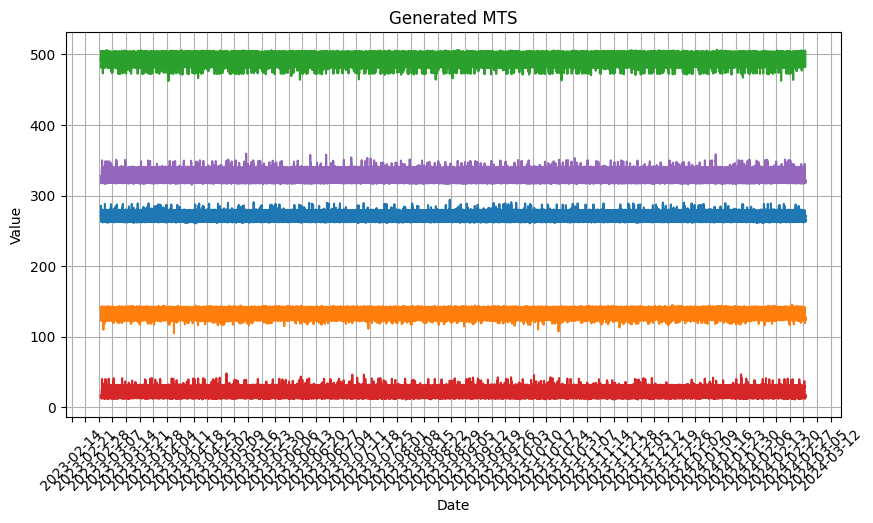

torch.Size([5, 10484])


In [5]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="Seasonality",
                                                                            occurance=7,
                                                                            return_gen=True,
                                                                            anomalies=True)

after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])


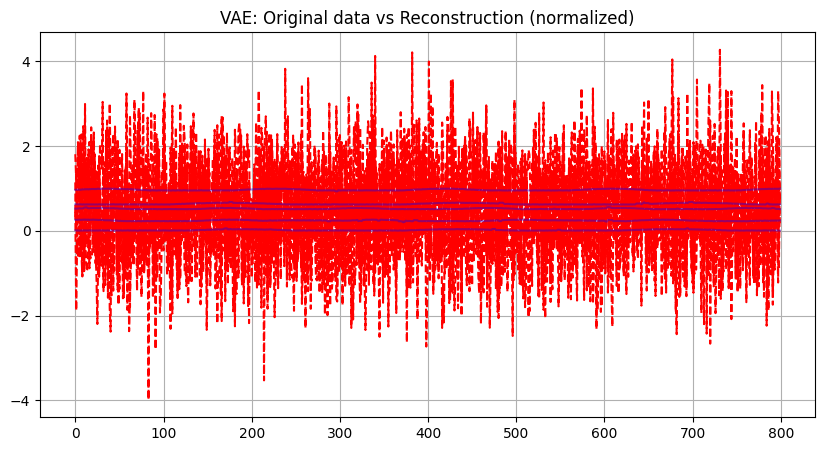

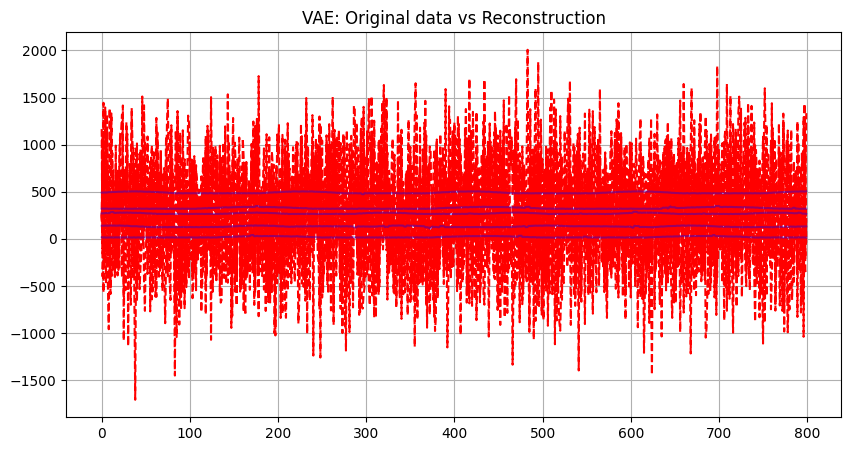

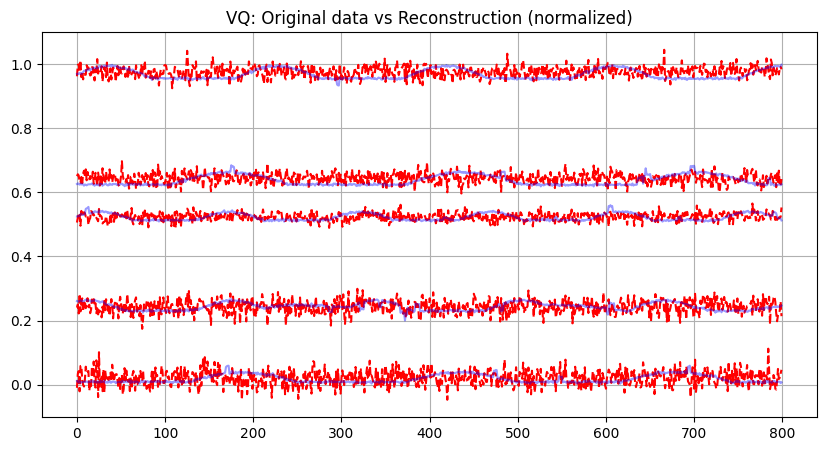

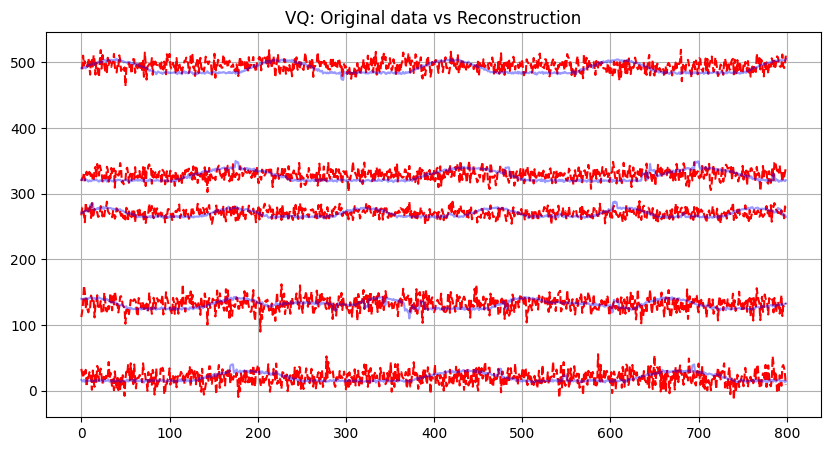

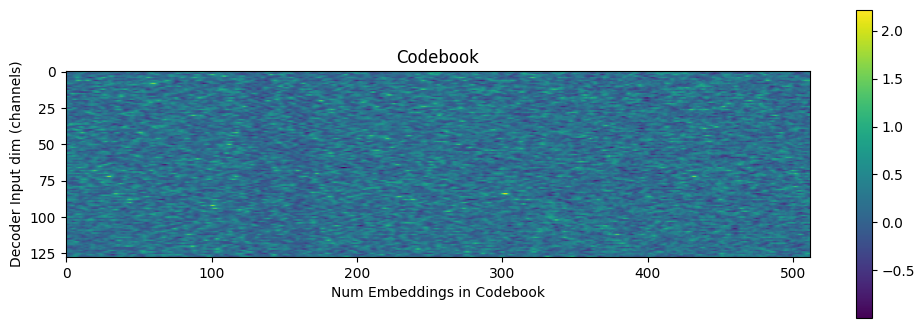

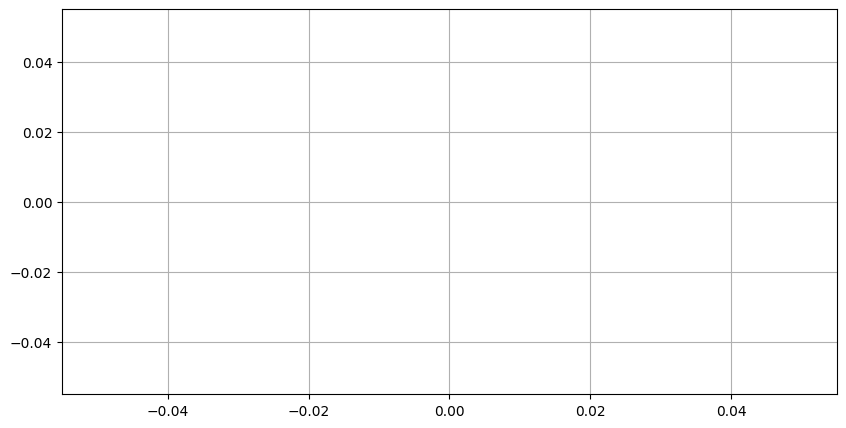

====> VQ: Sample 951 Average loss: 0.0252
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
Train Epoch: 952 [0/1 (0%)]	Loss: 2927.155603	 True Loss: 424437.562500
Train Epoch: 952 [0/1 (0%)]	Loss: 3.633029	 True Loss: 526.789246
====> VQ: Sample 952 Average loss: 0.0251
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
Train Epoch: 953 [0/1 (0%)]	Loss: 2934.433405	 True Loss: 425492.843750
Train Epoch: 953 [0/1 (0%)]	Loss: 3.559346	 True Loss: 516.105164
====> VQ: Sample 953 Average loss: 0.0245
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
Train Epoch: 954 [0/1 (0%)]	Loss: 2927.692672	 True Loss: 424515.437500
Train Epoch: 954 [0/1 (0%)]	Loss: 3.584279	 True Loss: 519.720520
====> VQ: Sample 954 Average loss: 0.0247
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])

Train Epoch: 981 [0/1 (0%)]	Loss: 3.449960	 True Loss: 500.244263
====> VQ: Sample 981 Average loss: 0.0238
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
Train Epoch: 982 [0/1 (0%)]	Loss: 2927.574784	 True Loss: 424498.343750
Train Epoch: 982 [0/1 (0%)]	Loss: 3.406457	 True Loss: 493.936218
====> VQ: Sample 982 Average loss: 0.0235
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
Train Epoch: 983 [0/1 (0%)]	Loss: 2935.798922	 True Loss: 425690.843750
Train Epoch: 983 [0/1 (0%)]	Loss: 3.433543	 True Loss: 497.863708
====> VQ: Sample 983 Average loss: 0.0237
after dropout torch.Size([145, 5, 576])
after dropout torch.Size([145, 5, 576])
output torch.Size([145, 5, 576])
Train Epoch: 984 [0/1 (0%)]	Loss: 2913.048707	 True Loss: 422392.062500
Train Epoch: 984 [0/1 (0%)]	Loss: 3.428505	 True Loss: 497.133240
====> VQ: Sample 984 Average loss: 0.0236
after dropout

In [22]:
args.min_max=True
np.set_printoptions(suppress=True)


for epoch in range(1, 1000):
    loss_vaet = train(vaet, train_data_long, args, opt_vaet, epoch)
    loss_vt = train(vt, train_data_long, args, opt_vt, epoch)
    
    if epoch%50 == 1:
        display.clear_output(wait=True)
        show_results_long(vaet, train_data_long, args, vq=False)
        show_results_long(vt, train_data_long, args, vq=True)
        

        
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vt/ len(train_data_long.dataset)))